In [1]:
#data processing
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

#data visualization
%matplotlib inline
import matplotlib.pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#data processing
import requests, copy, math
import scipy.interpolate

#data visualization
from matplotlib import ticker

#used for map projections
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [14]:
########### data processing #################
#####
# check if there is an error message
def check_error_message(ans,writeFlag=False):
    # ans: response JSON from an API query
    # writeFlag: bool, true == print verbose errors, if found
    # returns error code if found, or NaN if not.
    if isinstance(ans,dict) and 'message' in ans.keys() and 'code' in ans.keys():
        if writeFlag:
            print(str(ans['code']) + ': ' + ans['message'])
        ##### NOTE: we should include here below all the codes that do not return data as the user expects
        if ans['code'] >= 400 and ans['code'] != 404:
            print('Data were not returned')
            print(ans)
            raise Exception('No data')
        return ans['code']        
    elif ans:
        return np.nan
#####
# check if the object is a list of dictionaries
def check_list_of_dict(lst,writeFlag=False):
    # lst: object to check if is a list of dicts
    # writeFlag: bool, true == verbose mode
    # return 1 if lst is a list of dicts, 0 ow
    if lst and isinstance(lst,list):
        if all(isinstance(i, dict) for i in lst):
            if writeFlag:
                print('Number of items: '+str(len(lst)))
            return 1
        else:
            if writeFlag:
                print(lst) 
            return 0
    else:
        if writeFlag:
            print(lst) 
        return 0 
######
def get_data_from_url(url,myAPIkey,writeFlag=False):
    # url: string url to attempt to query
    # myAPIkey: string API key, get yours at https://argovis-apikey-manager-atoc-argovis-dev.apps.containers02.colorado.edu/ 
    # myAPIkey can also be left empty '', yet in this case the user is more likely to exceed API request limits (and get HTTP 403 errors).
    # returns a dictionary representation of the reponse from the endpoint hit in url; empty list if 404.
    try:
        d_raw = requests.get(url,headers={"x-argokey": myAPIkey}).json()
        ans = check_error_message(ans=d_raw,writeFlag=writeFlag)
    except:
        print(url)
        raise Exception('No data')
    # check that data are a list of dictionaries as expected
    if ans == 404:
        return []
    elif np.isnan(ans) and check_list_of_dict(lst=d_raw,writeFlag=writeFlag) == 1:
        if writeFlag:
            print(url)
        return d_raw
    else:
        print(ans)
        raise Exception('Check object type and error code')
#####
def create_url(url_prefix, \
               startDate='',endDate='', \
               radius_km=[],center=[], \
               polygon=[],data='',presRange='', \
               source='',platform_id='',woceline='',profile_id=''):
    # url_prefix: string root of API routes
    # startDate [endDate]: string start [end] date to filter documents on, in ISO 8601 UTC datestrings ie 1999-12-31T00:00:00Z
    # radius_km: float distance to search in proximity search; must be passed with center
    # center: [lon, lat] list of center of proximity search; must be passed with radius_km
    # polygon: [[lon0, lat0], [lon1, lat1], ... [lon0, lat0]] list of lists of lon/lat pairs describing polygon bounding box for region search; first coord must == last coord
    # data: comma delimited string of data variables to seatch for ANDed together, ie 'pres,temp,doxy'. Admits negation ('pres,temp,~doxy'); will return the actual measurements listed and filter for profiles that have them. Get metadata only by including 'metadata-only'.
    # presRange: comma delimited string indicating min and max pressure to return levels for, ie '0,100' for top 100 dbar
    # source: comma delimited string of data sources, ANDed together, such as 'argo_core' or 'cchdo_go-ship'. Accepts negation, ie 'argo_core,~argo_bgc'
    # platform_id: string indicating ID of Argo platform to search for
    # woceline: string indicating WOCE line to search for
    # profile_id: string indicating profile ID to search for
    # returns: string URL for performing the desired search (note all filters are ANDed together).

    url = url_prefix
    
    if startDate:
        url = url + '&startDate=' + startDate
    if endDate:
        url = url + '&endDate=' + endDate
        
    # regional queries
    if radius_km and center:
        url = url + '&radius=' + radius_km + '&center=' + center
    elif polygon:
        url = url + '&polygon=' + polygon
        
    # queries by variable data
    if data:
        url = url + '&data=' + data
    
    # queries by pressure range
    if presRange:
        url = url + '&presRange=' + presRange
    
    # queries by source
    if source:
        url = url + '&source=' + source
    
    # queries by platform id
    if platform_id:
        url = url + '&platform_id=' + platform_id
    
    # queries by woceline
    if woceline:
        url = url + '&woceline=' + woceline

    # queries by _id
    if profile_id:
        url = url + '&id=' + profile_id
        
    return url

def create_list_of_days(startDate,endDate,dt_tag='d'): 
    # dt_tag could be '30T', 'd', ...
    list_of_days = (pd.DataFrame(columns=['NULL'],
                            index=pd.date_range(startDate,endDate,
                                                freq=dt_tag)) #'d'
                                   .between_time('00:00','23:59')
                                   .index.strftime('%Y-%m-%dT%H:%M:%SZ')
                                   .tolist()
                )
    if list_of_days[-1] != endDate:
        list_of_days.append(endDate[0:11]+'23:59:59Z')
    return list_of_days

######
# create a list of days (in string format) from string dates in input, e.g.
#startDate='2021-05-01T00:00:00Z'
#endDate  ='2021-05-10T00:00:00Z'

######
########### data visualization #################

def plot_locations_withColor(lon,lat,cols,markersz=10,fnt_size=28):
    # plot a map with profile locations: if cols is only 1 string, then the same color is used for all the dots
    # if cols is a list of strings of the same length as e.g. lon, then one col per lon is used
    # else 'k' is used for color

    for i in np.arange(0,len(lon),1):
        if len(cols) == len(lon):
            col = cols[i]
        elif isinstance(col,str):
            col = cols
        else:
            col = 'k'
        plt.plot(lon[i],lat[i],marker='o',markersize=markersz,color=col,transform=ccrs.PlateCarree()) # cols_bySource[i]

# pick color based on list of sources
def select_color_byList(lst_in):
    if any("argo_bgc" in s for s in lst_in) and any("argo_deep" in s for s in lst_in):
        col = 'r'
    elif any("argo_bgc" in s for s in lst_in):
        col = 'g'
    elif any("argo_deep" in s for s in lst_in):
        col = 'b'
    elif any("argo_core" in s for s in lst_in):
        col = 'y'
    elif any("cchdo_go" in s for s in lst_in):
        col = 'k'
    else:
        col = 'gray'
    return col   
######    
# pick label
def set_ax_label(str_in):
    if str_in=='psal':
        ax_lab = 'Salinity [psu]'
    elif str_in=='temp':
        ax_lab = 'Temperature [degC]'
    elif str_in=='pres':
        ax_lab = 'Pressure [dbar]'
    elif str_in=='doxy':
        ax_lab = 'Oxygen, micromole/kg'
    else:
        ax_lab = str_in
    return ax_lab
#######
def qc_suffix(profile):
    # given a <profile> object 
    # return what the corresponding QC variable suffix.

    qcsuffix = None
    if 'argo' in profile['source_info'][0]['source'][0]:
        qcsuffix = '_argoqc'
    else:
        qcsuffix = '_woceqc'

    return qcsuffix    
#######
def qc(profile, qc_levels=[]):
    # given a <profile> and a list <qc_levels> of tuples (<variable>, <[allowed qcs]>),
    # Suppress all measurements that don't pass the specified QC.
    # If any measurements have qc present in <profiles.data> but don't have a level set in <qc_levels>,
    # require QC==1 for argo data and ==2 for CCHDO.

    qcsuffix = qc_suffix(profile)        
    qclookup = dict(qc_levels)
    
    if 'data' in profile and 'data_keys' in profile:
        for k in profile['data_keys']:
            if qcsuffix not in k: 
                # insist all data comes with qc
                if k+qcsuffix not in profile['data_keys']:
                    print(k, 'present without its QC; please add', k+qcsuffix, 'to your data query.')
                    return None
                if k in qclookup:
                    profile = mask_QC(profile, k, qclookup[k])
                elif qcsuffix == '_argoqc':
                    profile = mask_QC(profile, k, [1]) # default QC==1 for Argo 
                elif qcsuffix == '_woceqc':
                    profile = mask_QC(profile, k, [2]) # default QC==1,2 for CCHDO
    return profile
######            
def mask_QC(profile, variable, allowed_qc):
    # given a <profile> object, set <variable> to None if its QC flag is not in the list <allowed_qc>, 
    # and return the resulting profile object

    qcsuffix = qc_suffix(profile)  

    # helper for masking a single level dict; missing QC info == failed
    def m(level, var,qc,allowed_qc):
        if not level[qc] or level[qc] not in allowed_qc:
            level[var] = None
        return level


    masked_profile = copy.deepcopy(profile) # don't mutate the original
    if 'data' in masked_profile and variable in masked_profile['data_keys'] and variable+qcsuffix in masked_profile['data_keys']:
        masked_profile['data'] = [m(level,variable,variable+qcsuffix,allowed_qc) for level in masked_profile['data']]

    return masked_profile
######
def simple_plot(profile, variable, variable_qc=None):

    if 'data' in profile and variable in profile['data_keys']:
        if variable_qc and variable_qc in profile['data_keys']:
            plt.scatter([x[variable] for x in profile['data']],[y['pres'] for y in profile['data']], c=[c[variable_qc] for c in profile['data']])
            plt.colorbar()
        else:
            plt.scatter([x[variable] for x in profile['data']],[y['pres'] for y in profile['data']])
    
    plt.xlabel(variable)
    plt.ylabel('pres')
    plt.gca().invert_yaxis()

## URL and API

We add the URL and API_KEY here to query the data.

In [15]:
# prefix to use with all API queries
URL_PREFIX = 'https://argovis-api.colorado.edu'
API_KEY   = ''

## Interactive plotting

In [20]:
class InteractivePlotter:
    
    def __init__(self, polygon_bounding_box, 
                 startDate, endDate, 
                 info_to_store,
                 source_all,
                 dx = 10, dy = 10, 
                 MAX_POINTS = 10, 
                 central_long = -30):
        
        self.polygon_bounding_box = polygon_bounding_box
        self.startDate = startDate
        self.endDate = endDate
        
        self.info_to_store = info_to_store
        self.source_all = source_all
        
        self.dx = dx
        self.dy = dy
        self.MAX_POINTS = MAX_POINTS
        self.central_long = central_long
        
    def get_bounding_box_lon_lat_dict(self):

        self.polygon_lon_lat_dict = polygon_lon_lat(self.polygon_bounding_box)
    
    def setup_plot(self):
        
        self.lon_all = []
        self.lat_all = []
        dx = self.dx
        dy = self.dy
        
        self.fig = plt.figure(figsize=(10,10))
        
        self.lon_all = self.lon_all + self.polygon_lon_lat_dict['lon']
        self.lat_all = self.lat_all + self.polygon_lon_lat_dict['lat']
        
        self.ax, self.gl, self.usemap_proj = self.set_up_map(set_extent_info=[min(self.lon_all)-dx,max(self.lon_all)+dx,min(self.lat_all)-dy,max(self.lat_all)+dy],
                                 central_long=self.central_long,
                                 delta_lonGrid=15, delta_latGrid= 15,fnt_size=28)
    
        # plot the locations of the porofiles and polygon
        if self.polygon_lon_lat_dict:
            plt.plot(self.polygon_lon_lat_dict['lon'],self.polygon_lon_lat_dict['lat'],'--r',transform=ccrs.PlateCarree()) 
        
        text=self.ax.text(0,0, "", va="bottom", ha="left")

        self.polygon_coords = []

        i = 0
        # Function to print mouse click event coordinates
        def onclick(event):
            
            if i <= self.MAX_POINTS:
                text.set_text(f'{event.xdata}, {event.ydata}')
                self.polygon_coords.append([event.xdata, event.ydata])
                plt.plot(event.xdata, event.ydata, marker="o", markerfacecolor="red")
            else: 
                # Warning does not print for some reason
                warnings.warn(f"MAX_POINTS = {MAX_POINTS} exceeded.")
              
            # This line should be used to limit user input but it breaks the code
            #i=i+1    

        # Bind the button_press_event with the onclick() method
        self.fig.canvas.mpl_connect('button_press_event', onclick)
        
        # Display the plot
        plt.show()
        
    def plot_user_input(self):
        
        #         origin = np.array([-57, 0.])
        #         origin_true = np.array([np.min(self.lon_all)-self.dx,np.min(self.lat_all)-self.dy])

        delta = np.array([self.central_long, 0.])

        ### 3 points needed to form a polygon, and first point is mentioned twice in the list
        if len(self.polygon_coords) >= 3: 
            self.polygon = '['
            for i in range(len(self.polygon_coords)-1):
                self.polygon = self.polygon + f'[{delta[0]+self.polygon_coords[i][0]}, {delta[1]+self.polygon_coords[i][1]}],'
            self.polygon = self.polygon + f'[{delta[0]+self.polygon_coords[-1][0]}, {delta[1]+self.polygon_coords[-1][1]}],'
            ### Remove this later
            self.polygon = self.polygon + f'[{delta[0]+self.polygon_coords[0][0]}, {delta[1]+self.polygon_coords[0][1]}]'
            self.polygon = self.polygon + ']'

            self.user_polygon_lon_lat_dict = self.polygon_lon_lat(self.polygon)

            plt.plot(self.user_polygon_lon_lat_dict['lon'],self.user_polygon_lon_lat_dict['lat'],'-k')
            plt.show()
        else:
            raise Exception("Unable to form polygon, at least 4 points required in polygon_coords")
            
    def get_data_and_plot(self):
        
        startDate = self.startDate
        endDate   = self.endDate

        # helper function parameters
        ## list of parameters to extract from dataframes to dictionaries for plotting, see get_info_from_df
        info_to_store = self.info_to_store
        source_all = self.source_all
        
        for isource in source_all:
            self.bfr_df = self.get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                        url_prefix=URL_PREFIX+'/profiles?', \
                                        myAPIkey=API_KEY, \
                                        source=isource, \
                                        polygon=self.polygon, \
                                        dt_tag='365d',writeFlag=True)
            if not self.bfr_df.empty:
                self.bfr_info = self.get_info_from_df(df=self.bfr_df,info_to_store=self.info_to_store)
                ###### let's plot the polygon and the profile locations color coded by source
                self.set_map_and_plot_locations_withColor(lon=self.bfr_info['lon'],lat=self.bfr_info['lat'], \
                                             cols=self.bfr_info['cols_bySource'], \
                                             polygon_lon_lat_dict=self.user_polygon_lon_lat_dict)
                plt.title('source: ' + isource,fontsize=28)

    @staticmethod
    def set_up_map(set_extent_info,central_long=180,delta_lonGrid=30,delta_latGrid=30,fnt_size=28):
        # set_extent_info: [min lon, max lon, min lat, max lat] for mapping region
        # central_long: central longitude for map projection
        # delta_lonGrid: how close in degrees to space longitude ticks
        # delta_latGrid: how close in degrees to space latitude ticks
        # fnt_size: x/y axis label font size

        # this declares a recentered projection for Pacific areas
        usemap_proj = ccrs.PlateCarree(central_longitude=central_long)
        usemap_proj._threshold /= 20.  # to make greatcircle smooth

        ax = plt.axes(projection=usemap_proj)
        # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
        ax.set_extent(set_extent_info, crs=ccrs.PlateCarree())

        gl = ax.gridlines(draw_labels=True,color='black')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlocator = ticker.FixedLocator(np.arange(-180,180,delta_lonGrid))
        gl.ylocator = ticker.FixedLocator(np.arange(-90,90,delta_latGrid))

        gl.xlabel_style = {'size': fnt_size}
        gl.ylabel_style = {'size': fnt_size}

        ax.coastlines()
        ax.add_feature(cft.LAND)#, color='lightgray'
        ax.add_feature(cft.OCEAN)
        ax.add_feature(cft.COASTLINE)
        ax.add_feature(cft.BORDERS, linestyle=':')

        geodetic = ccrs.Geodetic()
        return ax, gl, usemap_proj
    
    @staticmethod
    def polygon_lon_lat(polygon_bounding_box):
        # polygon_bounding_box: string value of polygon search parameter, ie "[[lon0,lat0],[lon1,lat1],...,[lon0,lat0]]"
        # convert the polygon shape to lon and lat and save in a dictionary
        polygon_lon_lat_dict = {
                'lon': [float(i) for i in ((polygon_bounding_box.replace('[','')).replace(']','')).split(',')[0::2]],
                'lat': [float(i) for i in ((polygon_bounding_box.replace('[','')).replace(']','')).split(',')[1::2]]
                }
        
        return polygon_lon_lat_dict
    
    @staticmethod
    def get_info_from_df(df,info_to_store):
        # df: dataframe as returned by ie get_data_for_timeRange
        # info_to_store: list of strings indicating variables of interest
        # returns dictionary packing of listed info from dataframe

        if isinstance(df,pd.DataFrame):
            lon  = []
            lat  = []
            date = []
            cols_bySource=[]
            ids  = []
            woce_line = []

            lst_out = []

            for i in np.arange(0,len(df),1):
                #
                if any("lon" in s for s in info_to_store) or  any("lat" in s for s in info_to_store):
                    lon.append(df.geolocation[i]['coordinates'][0])
                    lat.append(df.geolocation[i]['coordinates'][1])
                #
                if any("date" in s for s in info_to_store):
                    date.append(df.timestamp[i][0:-5]+'Z')
                #
                if any("ids" in s for s in info_to_store):
                    ids.append(df._id[i])
                #
                if any("cols_bySource" in s for s in info_to_store):
                    bfr_source= []
                    for jsource in df.source_info[i]:
                        bfr_source = bfr_source + jsource['source']
                    cols_bySource.append(select_color_byList(lst_in=bfr_source))
                # 
                if any("woce_line" in s for s in info_to_store):
                    if "woce_line" in df.keys():
                        woce_line.append(df.woce_line[i])

            for i in info_to_store:
                if len(eval(i)) ==len(df) or not eval(i):
                    eval('lst_out.append('+ i +')')
                else:
                    raise Exception('check length')

            dict_info = {}
            for i,ival in zip(info_to_store,lst_out):
                if ival:
                    dict_info[i] = ival
        return dict_info

    @staticmethod    
    def set_map_and_plot_locations_withColor(lon,lat,cols,polygon_lon_lat_dict=[],markersz=10,dx=15,dy=15,central_long=-30, \
                                             delta_lonGrid=15,delta_latGrid=15,fnt_size=28, \
                                             fig_size=(10,10)):
        # lon: list of all longitudes of interest
        # lat: list of all latitudes of interest
        # polygon_lon_lat_dict: dictionary of longitudes and latitudes describing polygon region, see polygon_lon_lat function
        # markersz: scatterplot marker size
        # dx: degrees of margin space in longitude
        # dy: degrees of margin space in latitude
        # central_long, delta_lonGrid, delta_latGrid, fnt_size: see set_up_map
        # fig_size: matplotlib figure size

        # set up the map
        fig = plt.figure(figsize=fig_size)
        lon_all = lon
        lat_all = lat
        if polygon_lon_lat_dict:
            lon_all = lon_all + polygon_lon_lat_dict['lon']
            lat_all = lat_all + polygon_lon_lat_dict['lat']
        ax, gl, usemap_proj = set_up_map(set_extent_info=[min(lon_all)-dx,max(lon_all)+dx,min(lat_all)-dy,max(lat_all)+dy],
                                         central_long=central_long,
                                         delta_lonGrid=delta_lonGrid,delta_latGrid=delta_latGrid,fnt_size=fnt_size,
                                         )
        # plot the locations of the porofiles and polygon
        if polygon_lon_lat_dict:
            plt.plot(polygon_lon_lat_dict['lon'],polygon_lon_lat_dict['lat'],'-k',transform=ccrs.PlateCarree()) 
        plot_locations_withColor(lon=lon,lat=lat, \
                                 cols=cols,markersz=markersz,fnt_size=28)

    
    @staticmethod
    def get_data_for_timeRange(startDate,endDate,url_prefix, \
                         myAPIkey,\
                         radius_km=[],center=[], \
                         polygon=[],data='',presRange='', \
                         source='',platform_id='',woceline='', \
                         dt_tag='d',writeFlag=False):
        # all inputs as create_url, excpet:
        # myAPIkey: string API key for Argovis API
        # dt_tag: frequency tag as defined at https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases; 
        # determines how much data is downloaded per request (we suggest 'd' to avoid requesting too much data all at once; it should be tuned based e.g. 
        # on the size of the region of interest)
        # returns a dataframe describing the data returned by the specified query string filters

        list_of_days = create_list_of_days(startDate,endDate,dt_tag=dt_tag)
        info_ALL = []
        for i in np.arange(0,len(list_of_days)-1):
            url_to_use = create_url(url_prefix=url_prefix, \
                                   startDate=list_of_days[i], \
                                   endDate=list_of_days[i+1], \
                                   radius_km=radius_km,center=center, \
                                   polygon=polygon,data=data,presRange=presRange, \
                                   source=source,platform_id=platform_id,woceline=woceline)
            #print(url_to_use)
            info_ALL   = info_ALL + get_data_from_url(url=url_to_use,myAPIkey=myAPIkey,writeFlag=writeFlag)

        info_ALL = pd.DataFrame(info_ALL)

        return info_ALL

Next, we add some time stamps and bounds for a rectangular block, within which the user should choose the polygon they want.

After running the cell below, the user needs to choose at least 3 points to form a polygon by clicking on the plot.

<IPython.core.display.Javascript object>


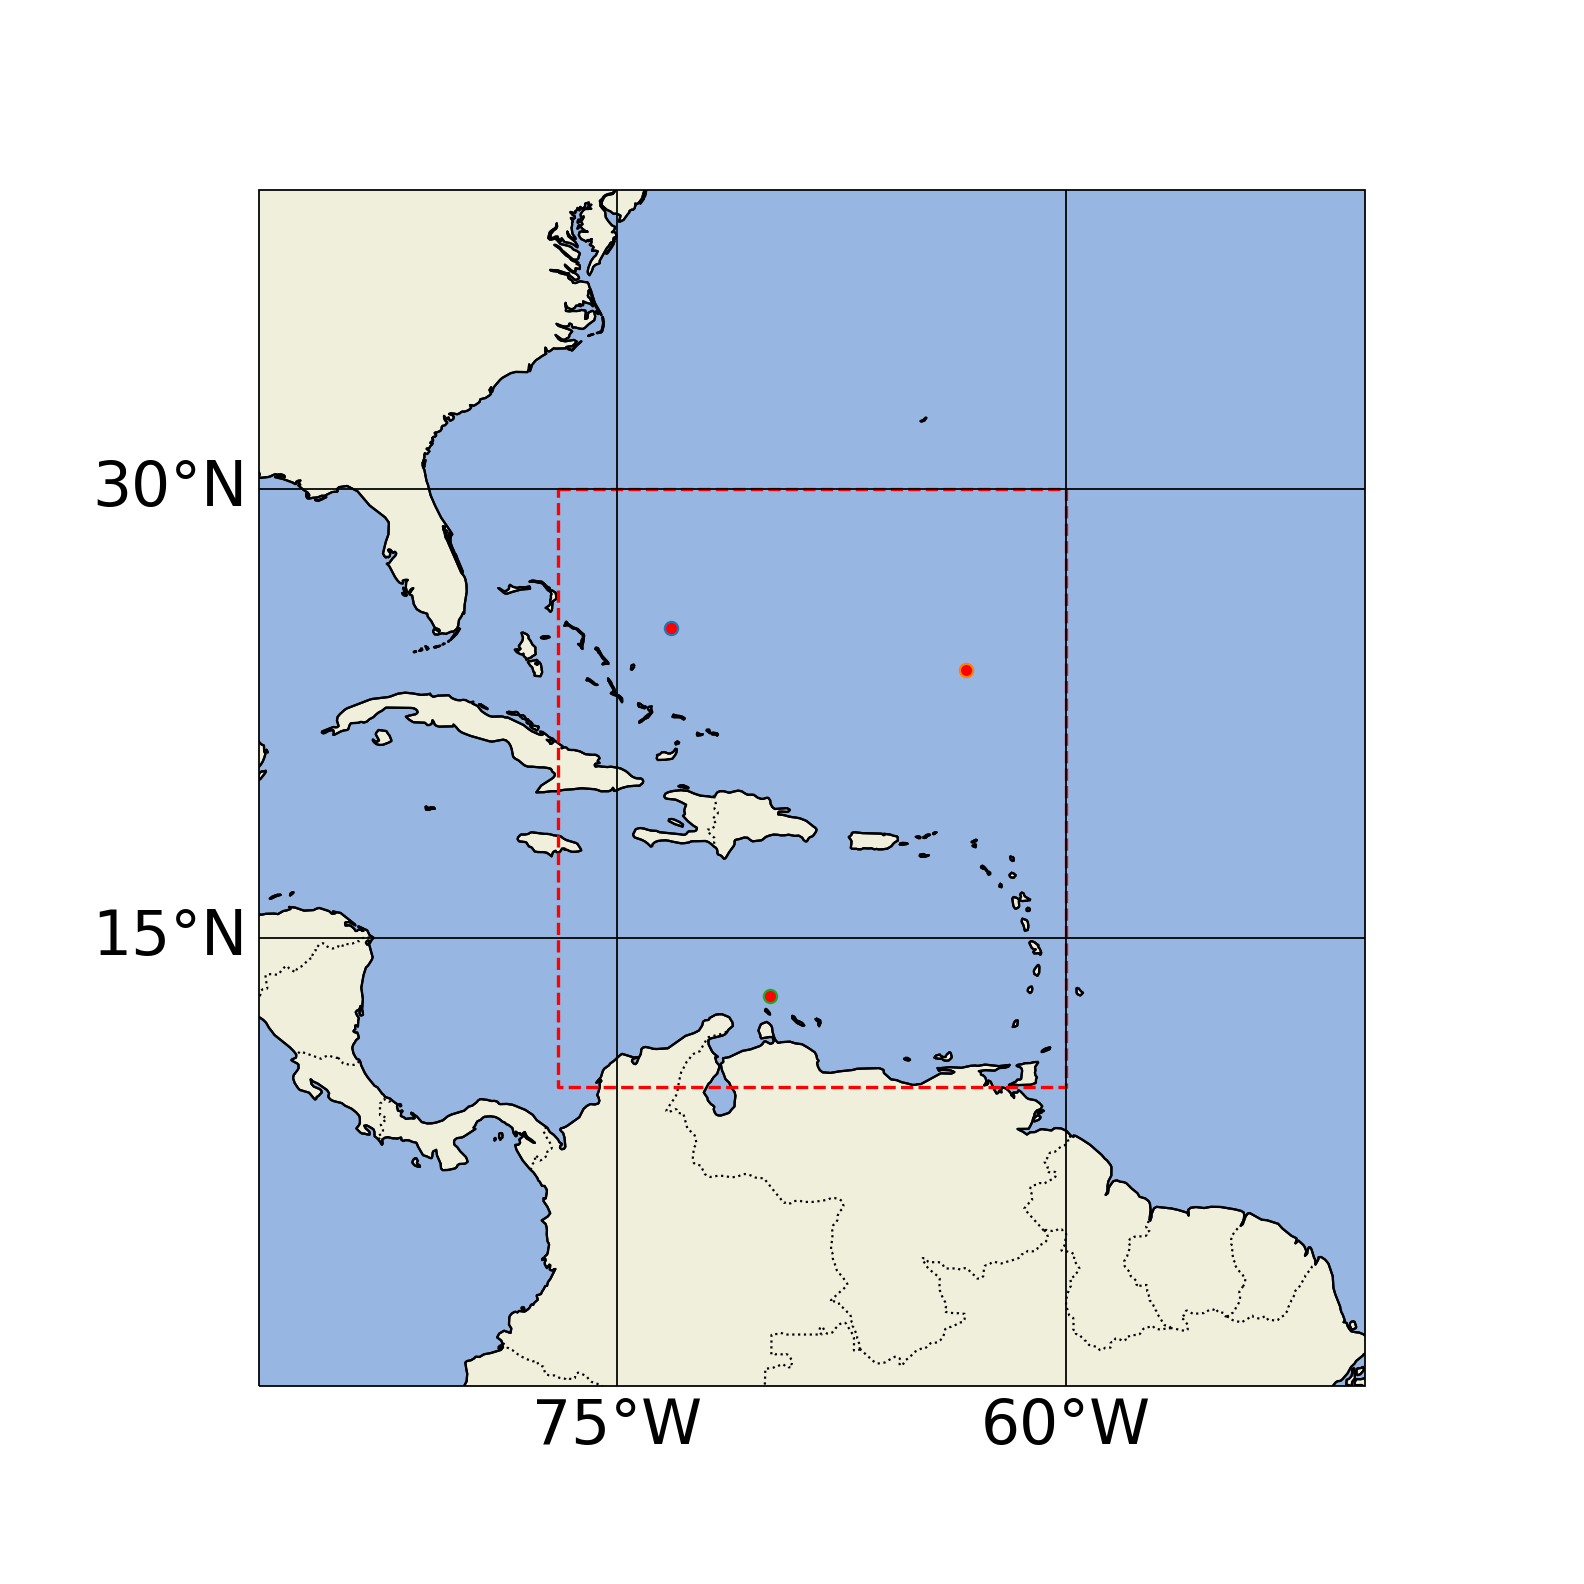

In [21]:
%matplotlib notebook

startDate = '2021-04-20T00:00:00Z'
endDate   = '2021-05-02T00:00:00Z'
# To see what this polygon looks like, visit https://argovis.colorado.edu/ng/home?mapProj=WM&presRange=%5B0,2000%5D&selectionStartDate=2022-03-31T22:30:45Z&selectionEndDate=2022-04-14T22:30:45Z&threeDayEndDate=2022-04-12T22:30:45&shapes=%5B%5B%5B22.105999,-76.289063%5D,%5B26.902477,-72.597656%5D,%5B26.084682,-66.395555%5D,%5B25.005973,-60.292969%5D,%5B10.833306,-65.566406%5D,%5B11.942098,-72.133142%5D,%5B22.105999,-76.289063%5D%5D%5D&includeRealtime=true&onlyBGC=false&onlyDeep=false&threeDayToggle=false
polygon_bounding_box = '[[-77.0,30.0],[-60.0,30.0],[-60.0,10.0],[-77.0,10.0],[-77.0,30.0]]'
info_to_store = ['lon','lat','date','cols_bySource','ids','woce_line']
source_all = ['argo_core','argo_bgc','cchdo_go-ship']

IP = InteractivePlotter(polygon_bounding_box, startDate, endDate, info_to_store, source_all)
IP.get_bounding_box_lon_lat_dict()
IP.setup_plot()

Run this block to plot the polygon co-ordinates.

In [22]:
IP.plot_user_input()

Finally, run this cell to get the data within the polygon.

Number of items: 24
https://argovis-api.colorado.edu/profiles?&startDate=2021-04-20T00:00:00Z&endDate=2021-05-02T23:59:59Z&polygon=[[-73.19345755222717, 25.342099513008566],[-63.33326623508222, 23.94401268445816],[-69.88219927408147, 13.053652125223426],[-73.19345755222717, 25.342099513008566]]&source=argo_core


<IPython.core.display.Javascript object>


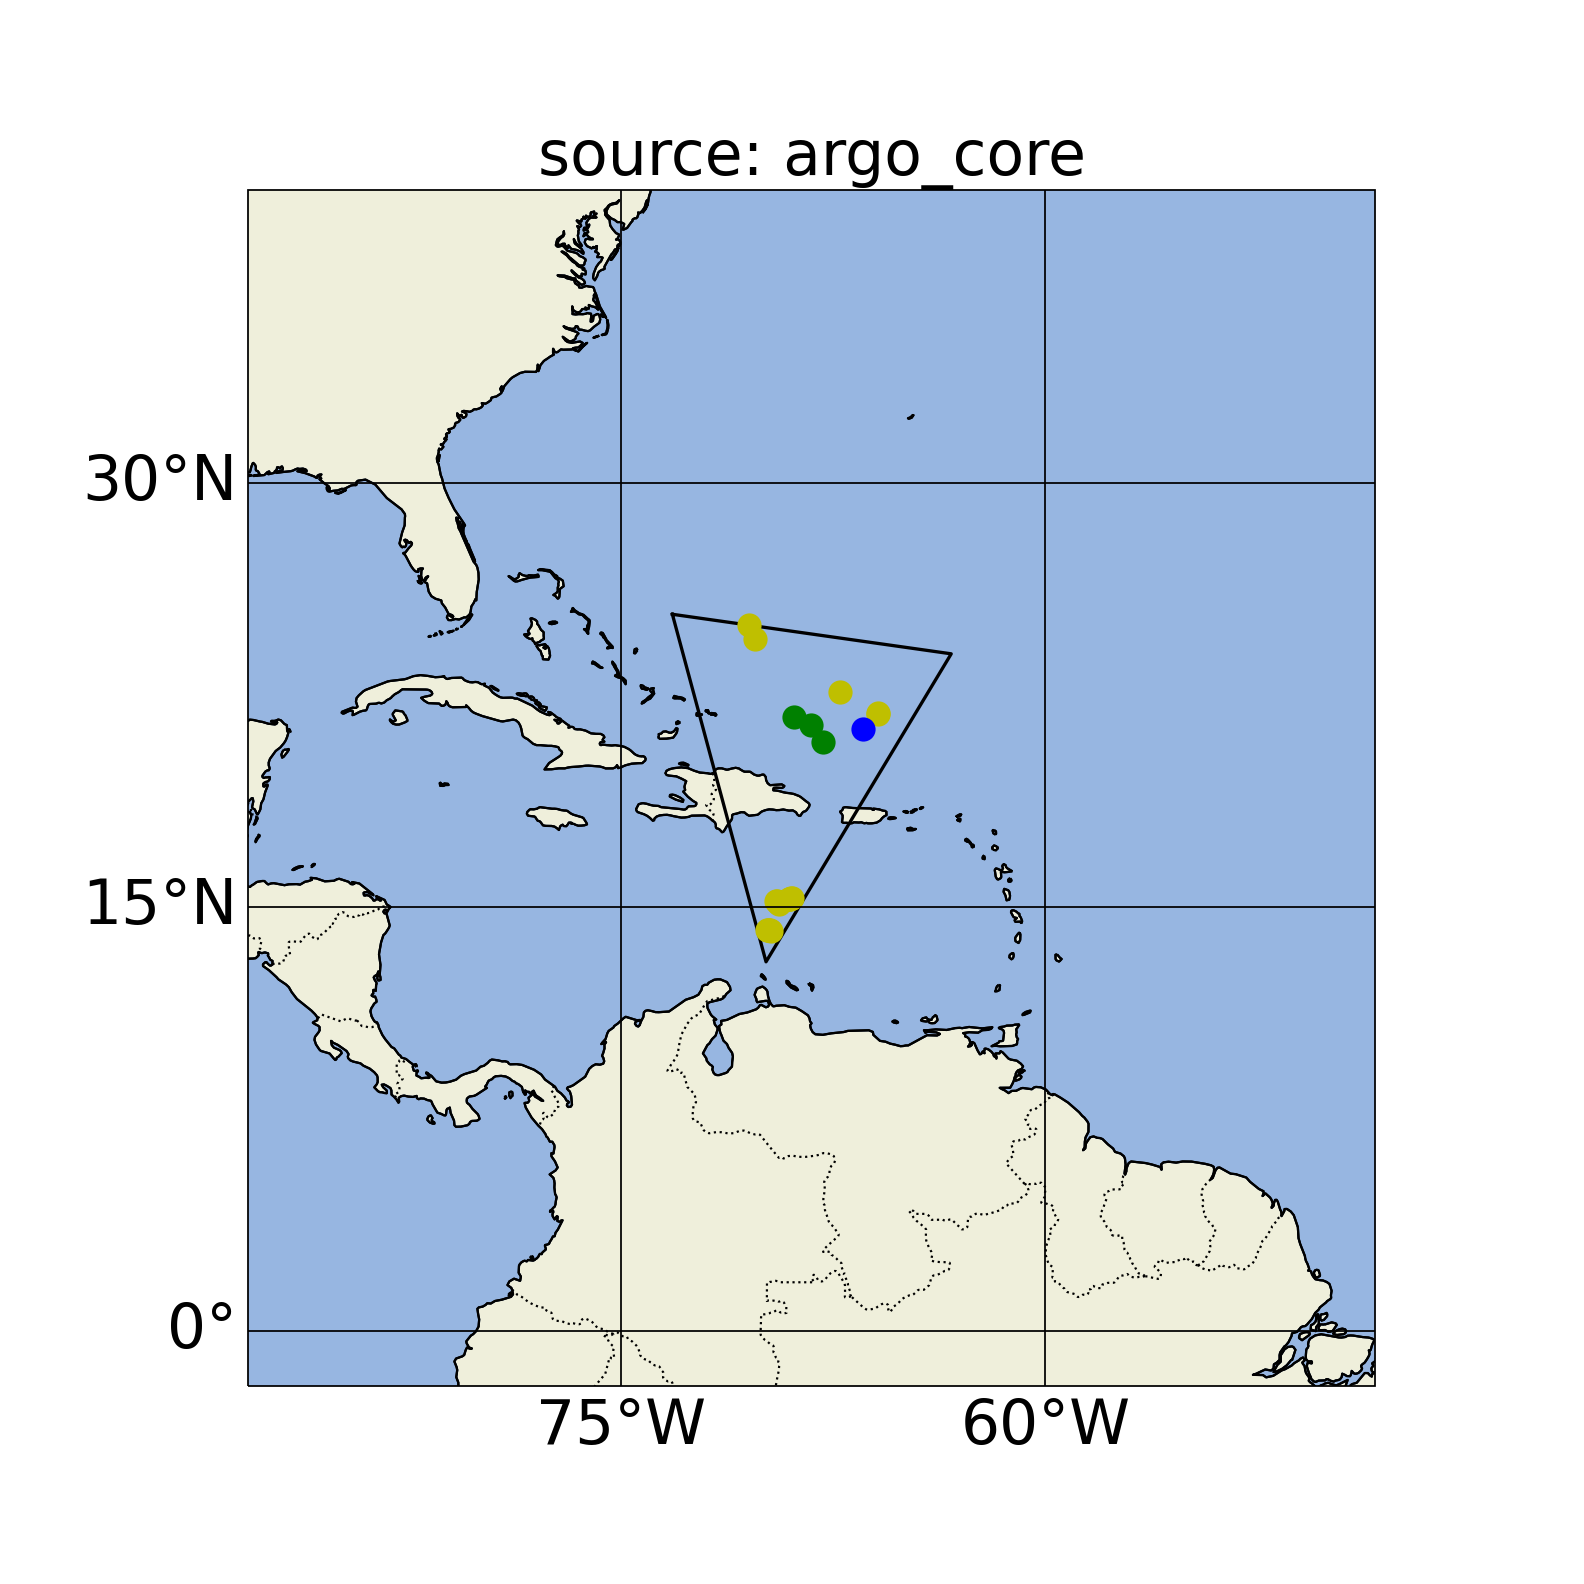

Number of items: 3
https://argovis-api.colorado.edu/profiles?&startDate=2021-04-20T00:00:00Z&endDate=2021-05-02T23:59:59Z&polygon=[[-73.19345755222717, 25.342099513008566],[-63.33326623508222, 23.94401268445816],[-69.88219927408147, 13.053652125223426],[-73.19345755222717, 25.342099513008566]]&source=argo_bgc


<IPython.core.display.Javascript object>


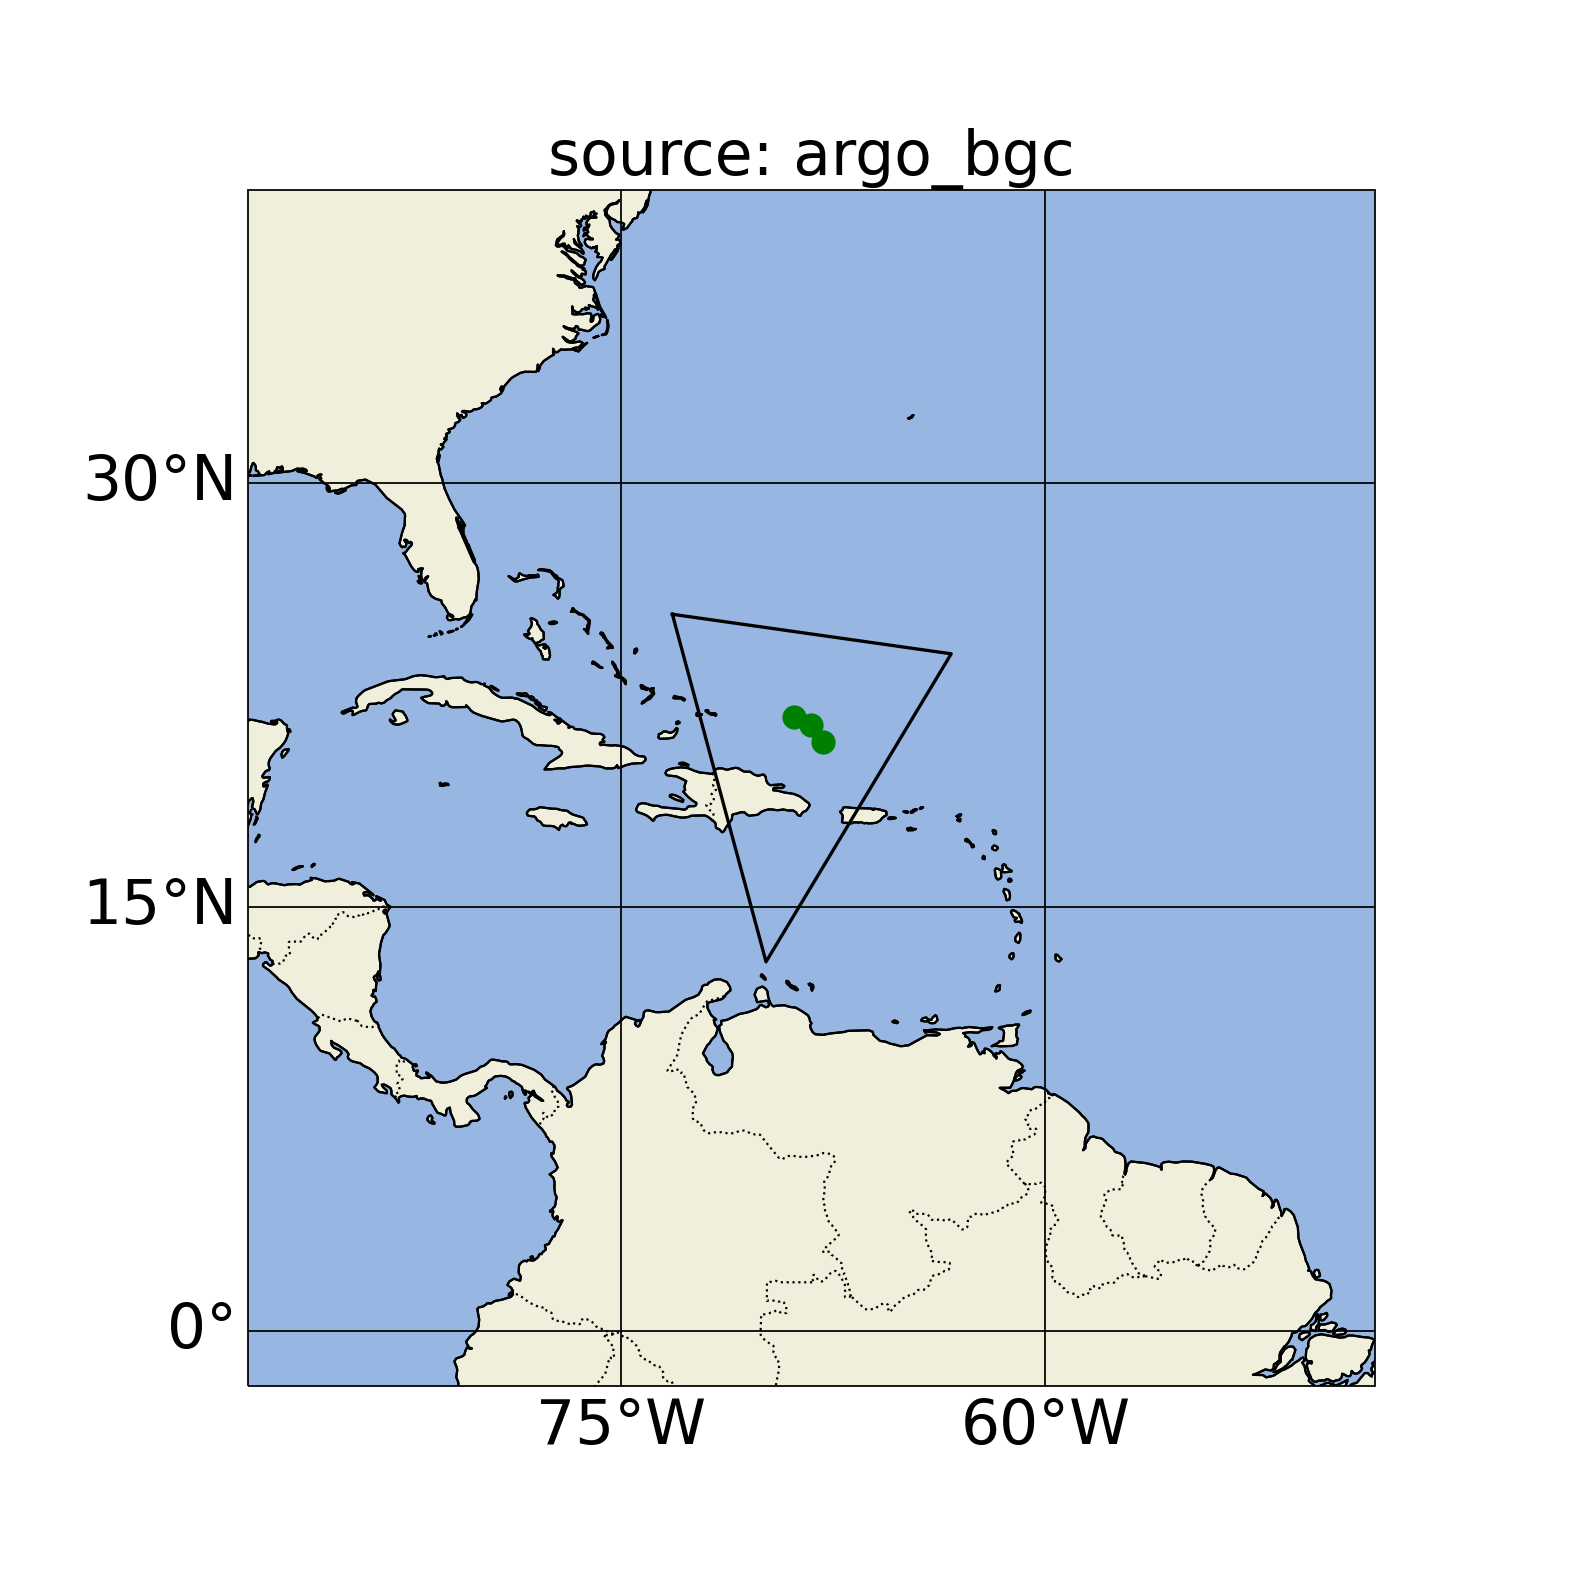

Number of items: 19
https://argovis-api.colorado.edu/profiles?&startDate=2021-04-20T00:00:00Z&endDate=2021-05-02T23:59:59Z&polygon=[[-73.19345755222717, 25.342099513008566],[-63.33326623508222, 23.94401268445816],[-69.88219927408147, 13.053652125223426],[-73.19345755222717, 25.342099513008566]]&source=cchdo_go-ship


<IPython.core.display.Javascript object>


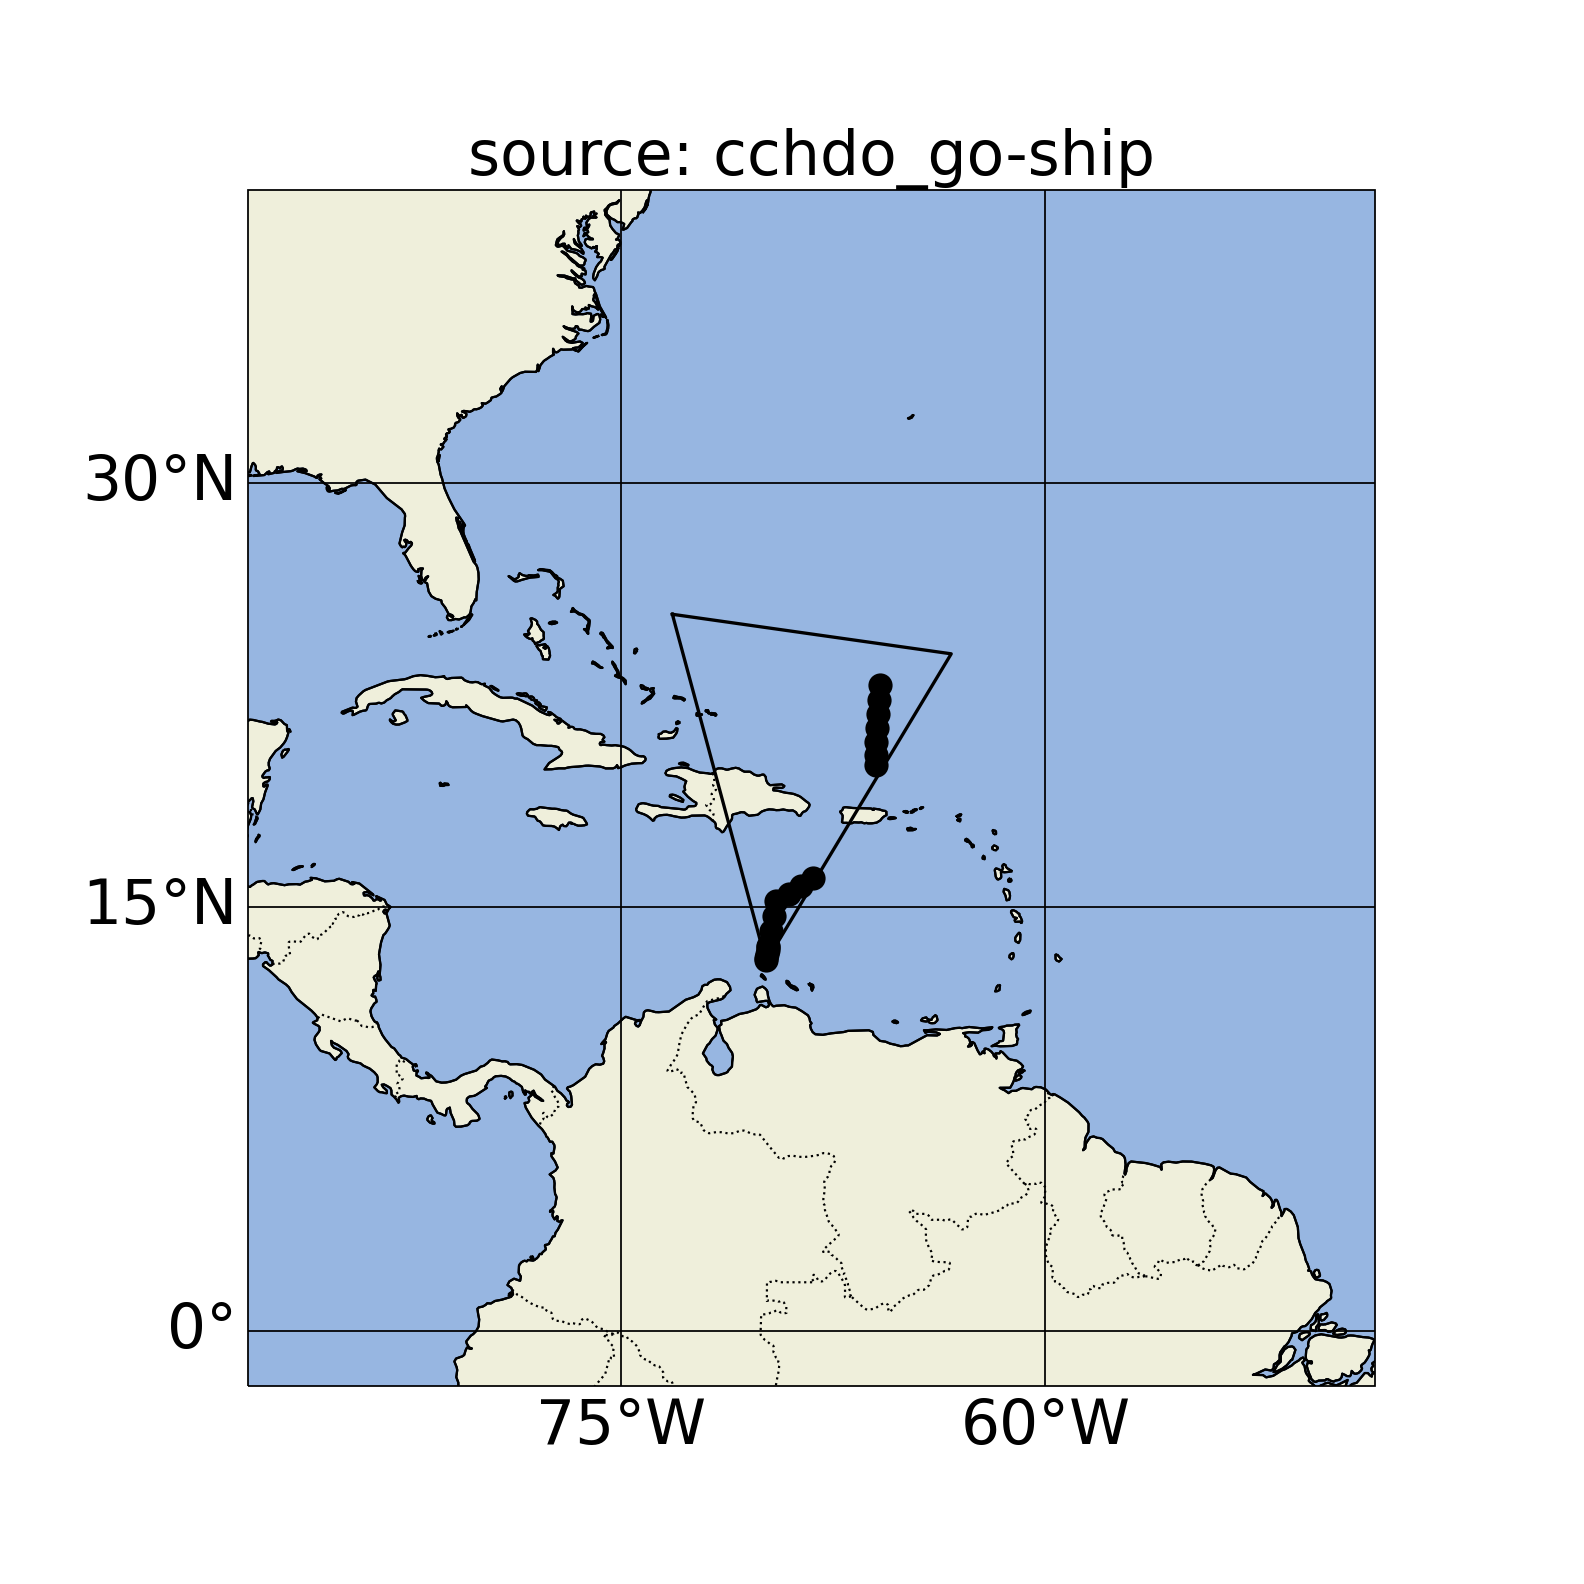

In [23]:
IP.get_data_and_plot()

## qc filtering and p-chip interpolation

In [171]:
class Binner:
    
    def __init__(self,
                 startDate, endDate,
                 polygon, source, 
                 data = 'psal,temp,psal_argoqc,pres_argoqc,temp_argoqc', 
                 dt_tag = '365d', URL_PREFIX = 'https://argovis-api.colorado.edu'):
        
        self.startDate = startDate
        self.endDate = endDate
        self.polygon = polygon
        self.source = source
        self.shape = str(polygon)
        self.dt_tag = dt_tag
        self.data = data
        self.URL_PREFIX = URL_PREFIX
        
        self.df = self.get_data_for_timeRange(startDate=self.startDate,endDate=self.endDate, \
                                url_prefix=self.URL_PREFIX+'/profiles?', \
                                myAPIkey='', \
                                source=self.source, \
                                polygon=self.shape, data=self.data, \
                                dt_tag=self.dt_tag,writeFlag=True)

    def QC_df(self, variables, qc_flag, qc_levels):
        """takes a list <qc_levels> of tuples (<variable>, <[allowed qcs]>
        and returns orignial df with variables set to Nan when qc is not in allowed qcs"""
        self.df_qc = pd.DataFrame()
        
        for i in range(len(self.df)):

            profile = self.df.loc[[i]].to_dict('records')

            for var in range(len(variables)): 
                
                data_key=variables[var]
                data_qc=qc_flag[var]
                allowed=qc_levels[var]

                mask = [x[data_qc] in allowed for x in profile[0]['data']]
                
                for i in range(len(profile[0]['data'])):
                    if mask[i] is False:
                        profile[0]['data'][i][data_key] = None
                    
            self.df_qc = self.df_qc.append(profile, ignore_index=True)
    
    def df_interpolation(self, pressure_levels = None):
        
        if pressure_levels is None:
            
            print("Pressure levels not specified for interpolation")
            print("Using default pressure_levels = list(range(0,2001))[0::100]")
            
            pressure_levels = list(range(0,2001))[0::100]
        
        self.df_interp = pd.DataFrame()   

        
        for i in range(len(self.df_qc)):

            profile = self.df_qc.loc[[i]].to_dict('records')

            interpolated_profile = [self.interpolate(p, pressure_levels, method='pchip') for p in profile]
            self.df_interp = self.df_interp.append(interpolated_profile)
            
    
    @staticmethod
    def get_data_for_timeRange(startDate,endDate,url_prefix, \
                         myAPIkey,\
                         radius_km=[],center=[], \
                         polygon=[],data='',presRange='', \
                         source='',platform_id='',woceline='', \
                         dt_tag='d',writeFlag=False):
        # all inputs as create_url, excpet:
        # myAPIkey: string API key for Argovis API
        # dt_tag: frequency tag as defined at https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases; 
        # determines how much data is downloaded per request (we suggest 'd' to avoid requesting too much data all at once; it should be tuned based e.g. 
        # on the size of the region of interest)
        # returns a dataframe describing the data returned by the specified query string filters

        list_of_days = create_list_of_days(startDate,endDate,dt_tag=dt_tag)
        info_ALL = []
        for i in np.arange(0,len(list_of_days)-1):
            url_to_use = create_url(url_prefix=url_prefix, \
                                   startDate=list_of_days[i], \
                                   endDate=list_of_days[i+1], \
                                   radius_km=radius_km,center=center, \
                                   polygon=polygon,data=data,presRange=presRange, \
                                   source=source,platform_id=platform_id,woceline=woceline)
            #print(url_to_use)
            info_ALL   = info_ALL + get_data_from_url(url=url_to_use,myAPIkey=myAPIkey,writeFlag=writeFlag)

        info_ALL = pd.DataFrame(info_ALL)

        return info_ALL
    
    @staticmethod
    def interpolate(profile, levels, method='pchip'):
        # given a <profile> and a list of desired pressure <levels>,
        # return a profile with profile.data levels at the desired pressure levels, with all available data interpolated to match
        # drop all QC and note `data_interpolated` in profile.data_warnings

        if method not in ['pchip', 'linear', 'nearest']:
            print('method must be one of pchip, linear or nearest')
            return None

        data_names = ['pres']
        interpolated_data = [levels]
        for key in profile['data_keys']:
            if '_argoqc' not in key and '_woceqc' not in key and key!='pres':
                
                finites = [(level['pres'], level[key]) for level in profile['data'] if level['pres'] is not None and level[key] is not None and not math.isnan(level['pres']) and not math.isnan(level[key])]
                pres = [x[0] for x in finites]
                data = [x[1] for x in finites]
                
                data_names.append(key)

                ### MODIFIED FROM ORIGINAL BY SHREYAS ###
                if all([x is None for x in data]):
                    interpolated_data.append([None]*len(levels))
                elif sum(x is not None for x in data) < 2:
                    interpolated_data.append([None]*len(levels))
                #########################################
                elif method == 'pchip':
                    interpolated_data.append(scipy.interpolate.pchip_interpolate(pres, data, levels))
                elif method == 'linear':
                    f = scipy.interpolate.interp1d(pres, data, kind='linear', fill_value='extrapolate')
                    interpolated_data.append([f(x) for x in levels])
                elif method == 'nearest':
                    f = scipy.interpolate.interp1d(pres, data, kind='nearest', fill_value='extrapolate')
                    interpolated_data.append([f(x) for x in levels])

        interpolated_levels = list(zip(*interpolated_data))
        data = [{data_names[i]:d[i] for i in range(len(data_names))} for d in interpolated_levels]
        interpolated_profile = copy.deepcopy(profile) # don't mutate the original
        interpolated_profile['data'] = data
        if 'data_warnings' in interpolated_profile:
            interpolated_profile['data_warnings'].append('data_interpolated')
        else:
            interpolated_profile['data_warnings'] = ['data_interpolated']
        return interpolated_profile


In [172]:
atlantic_coords = [[-40.078125,29.840644],[-33.368671,30.338837],[-26.614528,30.492027],
                    [-19.863281,30.297018],[-20.039063,-30.145127],[-26.724822,-30.384017],
                    [-33.419918,-30.281826],[-40.078125,-29.840644],[-40.078125,29.840644]]

### One can also supply polygon = IP.polygon_coords to make use of interactive input
B = Binner(startDate = '2021-04-20T00:00:00Z', endDate   = '2021-05-02T00:00:00Z',
          polygon = atlantic_coords, source = 'argo_core')

Number of items: 309
https://argovis-api.colorado.edu/profiles?&startDate=2021-04-20T00:00:00Z&endDate=2021-05-02T23:59:59Z&polygon=[[-40.078125, 29.840644], [-33.368671, 30.338837], [-26.614528, 30.492027], [-19.863281, 30.297018], [-20.039063, -30.145127], [-26.724822, -30.384017], [-33.419918, -30.281826], [-40.078125, -29.840644], [-40.078125, 29.840644]]&data=psal,temp,psal_argoqc,pres_argoqc,temp_argoqc&source=argo_core


In [173]:
B.QC_df(['pres','psal','temp'], ['pres_argoqc','psal_argoqc','temp_argoqc'], [[1,8],[1],[1]])
B.df_interpolation()

Pressure levels not specified for interpolation
Using default pressure_levels = list(range(0,2001))[0::100]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
25

In [174]:
profile = B.df.to_dict('records')
interpolated_profile = B.df_interp.to_dict('records')

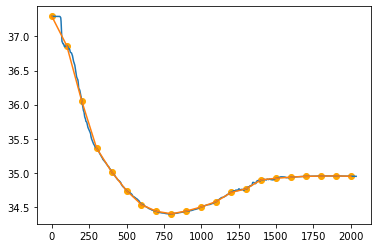

In [175]:
%matplotlib inline
plt.plot([x['pres'] for x in profile[0]['data']], [x['psal'] for x in profile[0]['data']])
plt.plot([x['pres'] for x in interpolated_profile[0]['data']], [x['psal'] for x in interpolated_profile[0]['data']])
plt.scatter([x['pres'] for x in interpolated_profile[0]['data']], [x['psal'] for x in interpolated_profile[0]['data']], c='orange')

Here we count the number of profiles that could not be interpolated because enough data points were not available.

In [176]:
count = 0
for i in range(len(profile)):
    if sum(x['psal'] is not None for x in profile[i]['data']) < 2:
        count = count + 1   
count

66